In [1]:
import os
import numpy as np
import silence_tensorflow.auto
import utils.training as training
import utils.testing as testing
import utils.loading as loading
import utils.models as models
import utils.anomaly_detection as anomaly_detection
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score

MACHINE_TYPE = 'fan'

In [2]:
X_normal, X_abnormal, X_normal_train, X_normal_test, X_test, y_test, X, y, _min, _max = loading.load_full_clips(MACHINE_TYPE, match_test_sizes=False)

X_abnormal_validation, X_abnormal_test = train_test_split(X_abnormal, test_size=0.8)
X_test = np.concatenate([X_normal_test, X_abnormal_test])
y_test = np.concatenate([np.zeros(X_normal_test.shape[0]), np.ones(X_abnormal_test.shape[0])])

cnnautoencoders = models.CNNAutoEncoders(MACHINE_TYPE, X_normal_train[0].shape)

X_train shape: (3260, 128, 320, 1)
X_test shape: (2290, 128, 320, 1)


In [3]:
(best_model, f1_scores, y_preds) = training.cnn_and_detector_cross_validation(
    create_model=cnnautoencoders.create_conv2d_model,
    get_encoder=cnnautoencoders.get_encoder,
    detector_class=anomaly_detection.LocalOutlierFactorDetector,
    X_normal_train=X_normal_train,
    X_abnormal_validation=X_abnormal_validation,
)

100%|██████████| 5/5 [04:29<00:00, 53.97s/it]


In [4]:
average_f1_score = np.mean(f1_scores)
print(f'Average F1 score: {average_f1_score}')
best_f1_score = max(f1_scores)
print(f'Best F1 score: {best_f1_score}')

Average F1 score: 0.8980105454629838
Best F1 score: 0.9159688503672048


63/63 [==============================] - 0s 6ms/step


,normal,abnormal
normal,735,80
abnormal,82,1098


              precision    recall  f1-score   support

      normal       0.90      0.90      0.90       815
    abnormal       0.93      0.93      0.93      1180

    accuracy                           0.92      1995
   macro avg       0.92      0.92      0.92      1995
weighted avg       0.92      0.92      0.92      1995



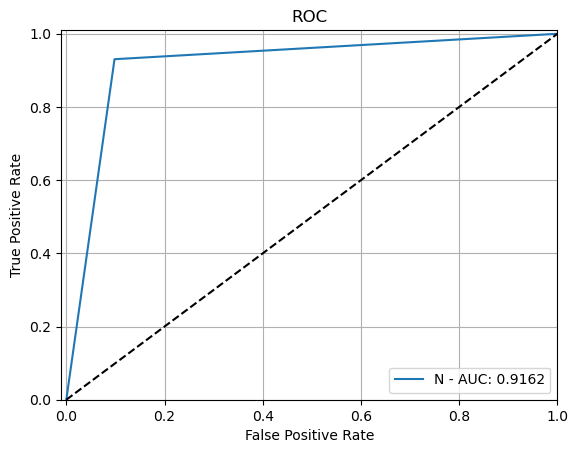

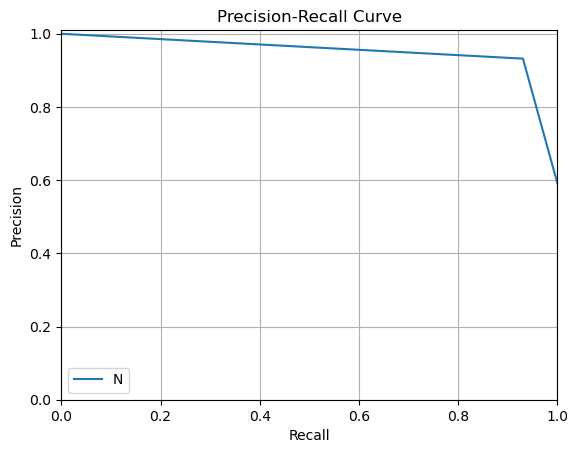

f1_score =0.9188123119878726, auc_score =0.9161744826869087


In [5]:
encoder, detector = best_model

test_embeddings = encoder.predict(X_test)
test_embeddings = test_embeddings.reshape(test_embeddings.shape[0], -1)
y_pred = detector.test_predict(test_embeddings, y_test)

f1_score = f1_score(y_test, y_pred, average='weighted')
auc_score = roc_auc_score(y_test, y_pred)
print(f'{f1_score =}, {auc_score =}')

In [6]:
loading.save_run(MACHINE_TYPE, cnnautoencoders.get_model_type(), encoder, detector, X_normal_train, X_normal_test, X_abnormal_validation, X_abnormal_test, _min, _max, f1_score, auc_score)